# test--节点插入、删除

value2
{'key': 'value'}
{'key': 'value2'}
{}


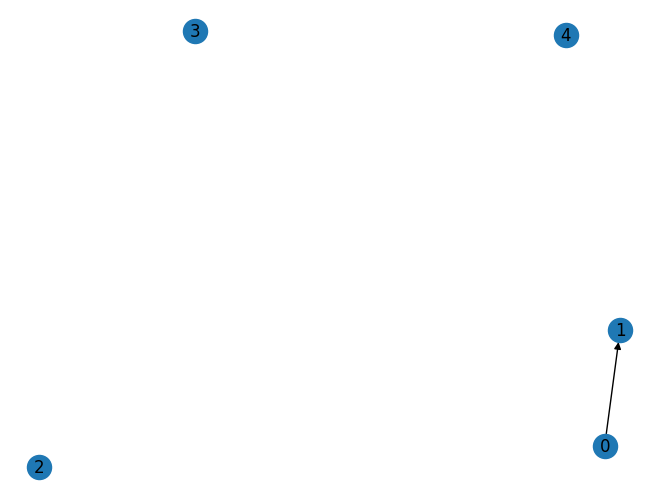

In [39]:
#添加节点
 
import networkx as nx
import matplotlib.pyplot as plt
 
G1 = nx.DiGraph()     
# G1.add_node(1,key = "value")            #建立一个空的无向图G
G1.add_nodes_from([(1,{"key":"value"}),(2, {"key":"value2"}),3])                  #添加一个节点1
G1.add_edges_from([(1,2)])
G1.nodes[1]['key']
for node_index in G1.successors(1):
    print(G1.nodes[node_index]['key'])

G2 = nx.DiGraph()
G2.add_nodes_from([1,2])
G = nx.disjoint_union(G1, G2)

for node, node_data in G1.nodes.items():
    print(node_data)

nx.draw(G, with_labels=True)
plt.show()


# test--后继节点、子图

In [4]:
import networkx as nx

# # 创建有向图
# G = nx.DiGraph()

# # 添加边
# edges = [
#     ('A', 'B'),
#     ('A', 'C'),
#     ('B', 'D'),
#     ('C', 'D'),
#     ('C', 'E'),
#     ('D', 'E')
# ]

# G.add_edges_from(edges)

# # nx.draw(G, with_labels=True)

# # 指定起始节点
# start_node = 'A'

# # 获取所有直接后继节
# successors = list(nx.descendants(G, 'A'))
# print("Direct successors of '{}': {}".format(start_node, successors))

# # 创建子图的节点列表（包括起始节点和其后继）
# subgraph_nodes = [start_node] + successors

# # 生成子图
# H = G.subgraph(subgraph_nodes)

# G.remove_nodes_from(["E", "C"])


# # 打印子图的节点和边
# print("Subgraph nodes:", G.nodes())
# print("Subgraph edges:", G.edges())

# # 可视化子图（可选）
# nx.draw(G, with_labels=True)

import networkx as nx
import matplotlib.pyplot as plt

G = nx.complete_graph(5)  # 生成一个完全图
nx.draw(G, with_labels=True)  # 绘制图形（带节点标签）
plt.savefig("graph.png", format="PNG")  # 保存为PNG文件
plt.clf()
nx.draw(G, with_labels=True)
plt.savefig("graph.png", format="PNG")
plt.close()  # 关闭绘图窗口，避免内存占用

# test--nextworkx转化为pyg

In [ ]:
import networkx as nx
import torch
from torch_geometric.data import Data

def convert_nx_to_pyg(G):
    # 获取所有节点并排序，确保顺序一致
    nodes = list(G.nodes())
    node_idx = {node: idx for idx, node in enumerate(nodes)}

    # 生成节点特征（例如，每个节点一个特征值为1）
    n_nodes = len(nodes)
    x = torch.ones(n_nodes, 1, dtype=torch.float32)
    print(x)
    # 处理边信息
    edges = list(G.edges())
    sources = [node_idx[e[0]] for e in edges]
    targets = [node_idx[e[1]] for e in edges]

    edge_index = torch.tensor([sources, targets], dtype=torch.long)

    return Data(x=x, edge_index=edge_index)

# 创建示例图
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2)])

# 转换图
data = convert_nx_to_pyg(G)


print(data)

tensor([[1.],
        [1.],
        [1.]])
Data(x=[3, 1], edge_index=[2, 2])


# test--自定义环境(继承gym.Env) + DQN + RlLib(强化学习框架)

In [3]:

import gymnasium
from gymnasium import spaces
import numpy as np
import random

class CustomEnv(gymnasium.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self, seed=None):
        super().__init__()
        self.n_actions = 2  # 动作空间的维度
        self.n_states = 3   # 状态空间的维度
        self.action_space = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.n_states,), dtype=np.float32)

        self._seed = seed
        if self._seed is not None:
            random.seed(self._seed)
            np.random.seed(self._seed)

    def reset(self):
        # Reset the environment and return the initial state
        self.state = np.array([np.random.uniform(-1, 1) for _ in range(self.n_states)])
        return self.state

    def step(self, action):
        # Execute one step in the environment
        reward = random.uniform(0, 1)
        done = False  # Episodes are not terminal by default
        next_state = np.array([np.random.uniform(-1, 1) for _ in range(self.n_states)])

        return next_state, reward, done, {}

    def render(self, mode='console'):
        print(f"Current state: {self.state}")

    def close(self):
        pass

    def is_continuous(self):
        return False

    def is_discrete(self):
        return True

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

### DQN算法实现部分（使用PyTorch）


import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQN_Agent:
    def __init__(self, env, batch_size=32, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=10000):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        input_size = env.observation_space.shape[0]
        output_size = env.action_space.n
        self.model = DQN(input_size, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        self.memory = deque(maxlen=10000)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.env.action_space.n - 1)

        with torch.no_grad():
            q_values = self.model(torch.FloatTensor(state))
            return q_values.argmax().item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([t[0] for t in minibatch])
        actions = np.array([t[1] for t in minibatch]).astype(np.int64)
        rewards = np.array([t[2] for t in minibatch]).astype(np.float32)
        next_states = np.array([t[3] for t in minibatch])
        dones = np.array([t[4] for t in minibatch]).astype(bool)

        # Convert to tensors
        states_t = torch.FloatTensor(states)
        actions_t = actions.long()
        rewards_t = rewards.unsqueeze(1)  # 增加一个维度，方便后续计算
        next_states_t = torch.FloatTensor(next_states)
        dones_t = dones.float().unsqueeze(1)

        current_q_values = self.model(states_t).gather(dim=1, index=actions_t.unsqueeze(1))

        with torch.no_grad():
            next_q_values = self.model(next_states_t).max(dim=1)[0].detach()

        target_q_values = rewards_t + (1 - dones_t) * self.gamma * next_q_values.unsqueeze(1)

        loss = self.criterion(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon_decay / (self.epsilon_decay + np.exp(-self.epsilon)))

### 使用RLlib整合代码


import ray
from ray import tune
from ray.tune.registry import register_env
from ray.rllib.env import BaseEnv

# 将自定义环境注册到Ray/RLLib
def env_creator(env_config):
    return CustomEnv()

register_env("CustomEnv-v0", env_creator)

# DQN模型的配置
config = {
    "env": "CustomEnv-v0",
    "num_workers": 3,
    "gamma": 0.99,
    "learning_rate": 0.001,
    "buffer_size": 10000,
    "batch_size": 32,
    "epsilon_start": 1.0,
    "epsilon_end": 0.01,
    "epsilon_decay": 10000,
}

ray.init()

# 启动训练过程
tune.run(
    "DQN",
    config=config,
    stop={"episode_reward_mean": 500},
)

ray.shutdown()

2025-02-14 09:59:49,469	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-14 09:59:50,425	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-02-14 09:59:50,443	WARNING algorithm_config.py:4726 -- You are running DQN on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-02-14 09:59:50,444	WARNING algorithm_config.py:4726 -- You are running DQN on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
(pid=34900) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(DQN pid=34900) 2025-02-

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: a7277ab932301c8614c5917b2e11662ffab04fb5d2a2b514048ec028 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 26118 Worker PID: 35037 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:00:59,169	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(DQN pid=34900) 2025-02-14 09:59:58,242	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future! [repeated 3x across cluster]
(SingleAgentEnvRunner pid=35037) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeat

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 5ef67aa513d4d4f93ba836981ad094cbdf14dd72d9b9313af2228f34 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 10729 Worker PID: 36439 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:02:06,461	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:02:06,461	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:02:06,461	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: The actor is

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: d7a22fde68cfd3ed649c02563cf64124d81bc6f551c796ee806ea41d Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 31367 Worker PID: 37662 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:03:10,470	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:03:10,470	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:03:10,470	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: The actor is

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: a5afbe94be16f3ce67210d6447a65000ed8a65174b3b56f723cfd0f6 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 33585 Worker PID: 38923 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:04:12,488	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=38922) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=38922) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=38922)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=38922) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 7d521623678ef5a150dfab1c3eb58e4d418350ce839d92a30df5ae49 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 28264 Worker PID: 40150 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:05:16,496	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=40149) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=40149) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=40149)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=40149) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 47354d8261ac8bcaf0cf8b7a0088ecd966cb92abdedfd63dc3bfb535 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 36708 Worker PID: 41242 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:06:22,495	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:06:22,496	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: RpcError: RPC Error message: Cancelling all calls; RPC Error details: . The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:06:22,496	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: T

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff7c669962a10c460863c7229c01000000 Worker ID: 8443272f76022987cf227401bcdc0d538f0476f7d4a0dc02f4db1eb0 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 11942 Worker PID: 42396 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:07:24,514	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=42396) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=42396) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=42396)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=42396) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 249f851cc279d3e943389c3728560611ced62b5addba96b4b2397e2b Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 22493 Worker PID: 43606 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:08:28,523	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=43605) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=43604) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=43604)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=43604) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: 5218125dc9b298d5c2778043e0dd808f94b139f62a7b13506f527b03 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 29905 Worker PID: 44767 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:09:32,532	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=44767) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=44767) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=44767)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=44767) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 4669a199656d83527259bb10707a2138ba99af593ba528754e3f84ba Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 30943 Worker PID: 45887 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:10:36,540	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=45887) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=45887) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=45887)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=45887) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: b7118d7f1aae3fbf366677981d6e234e3420f8675b00cce6eb3d2b72 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 14141 Worker PID: 47097 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:11:40,548	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=47097) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=47097) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=47097)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=47097) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffe714c762e5b6504c5ec14c0d01000000 Worker ID: ac65c1da51714d51090f3f7ce1d4f6ca251ddb9bf4edc4c2de2ce531 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 10445 Worker PID: 48295 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:12:44,559	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=48293) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=48293) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=48293)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=48293) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 4f3982e098a1fb96efa285f248d2b147ca185b3c6ce46caa73351e5d Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 22975 Worker PID: 49482 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:13:48,568	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=49482) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=49482) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=49482)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=49482) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff7c669962a10c460863c7229c01000000 Worker ID: e6ee381bebd517f2dd06813eabfeae86f2d3e05de145268f2ac305b2 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 19454 Worker PID: 50639 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:14:54,568	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:14:54,568	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:14:54,568	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: The actor is

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 94d79a6be5cf806aa07e8ae23a53eaf9623463dd0b623bcb6b06c1d9 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 12146 Worker PID: 52032 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:15:56,586	WARNING rollout_ops.py:121 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
(pid=52030) lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=52030) /data/homedata/lch/.local/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:167: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. [repeated 3x across cluster]
(SingleAgentEnvRunner pid=52030)   logger.deprecation( [repeated 6x across cluster]
(SingleAgentEnvRunner pid=52030) /data/homedata/lch/.l

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff5a53efdf420527e542a1f58e01000000 Worker ID: 17e7458f38eb0ea1075e38a3bcbe7e1eaae40831e229ecfdb446fc58 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 27299 Worker PID: 53278 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 3x across cluster]


(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:17:02,588	ERROR actor_manager.py:815 -- Ray error (The actor e714c762e5b6504c5ec14c0d01000000 is unavailable: The actor is temporarily unavailable: IOError: Fail all inflight tasks due to actor state change.. The task may or maynot have been executed on the actor.), taking actor 1 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:17:02,588	ERROR actor_manager.py:815 -- Ray error (The actor 7c669962a10c460863c7229c01000000 is unavailable: The actor is temporarily unavailable: RpcError: RPC Error message: Cancelling all calls; RPC Error details: . The task may or maynot have been executed on the actor.), taking actor 2 out of service.
(DQN(env=CustomEnv-v0; env-runners=3; learners=0; multi-agent=False) pid=34900) 2025-02-14 10:17:02,588	ERROR actor_manager.py:815 -- Ray error (The actor 5a53efdf420527e542a1f58e01000000 is unavailable: T

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff7c669962a10c460863c7229c01000000 Worker ID: 7caa363a18c1897ff15224680c4e41a00982b2fcd0d550e4b8334814 Node ID: 9798f6cdac4df82c223a14e689da0d4e4cb3b36cba83fae80bcebd65 Worker IP address: 49.52.27.20 Worker port: 32405 Worker PID: 53276 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. [repeated 2x across cluster]


# test--numpy

In [18]:
import numpy as np
v1 = np.zeros((0,2))
v2 = np.array([3,4]).reshape(1,-1)
v3 = np.array([5, 6]).reshape(1,-1)
v = np.vstack((v1, v2,v3))
print(v)
# x = x.softmax(0).detach().numpy()
# np.random.choice(x, 1, p=x)
print(np.unravel_index(3, (2,2)))
probs = [1/6,2/6,3/6]
action_idx = np.random.choice(range(0,len(probs)), 1, p=probs)
print(action_idx)
action_idx = np.argmax(probs)
print(action_idx)
print(np.power(2,3))
print(np.log(3))
print(np.power(2,-2*np.log2(3)))
x = np.random.randint(0,2)
print(x)
x = [1,2,3,4]
print(x[(1,2)])



[[3. 4.]
 [5. 6.]]
(1, 1)
[0]
2
8
1.0986122886681096
0.11111111111111112
0


TypeError: list indices must be integers or slices, not tuple

# test--Pytorch

In [1]:
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
torch.cuda.device_count()
v1 = torch.Tensor([1,2])
v2 = torch.Tensor([3,4])
v = torch.concatenate((v1,v2))
print(v.shape)
v = torch.Tensor([[1,2],[2,3]])
print(v.view(4))
x = torch.randn(64, 32)
print(x.dtype)
x = torch.rand((2,4))
x = x.view(-1)
print(x)
# flag = torch.Tensor([1,0])
# x = torch.where(flag > 0, x, torch.tensor(float("-inf")))
print(x)
x = torch.randn((2,2))
y = torch.randn((2,2))
z = torch.cat([x,y],dim=0)
print(z.shape)
# features = torch.randn((135, 7))
# pad_value = torch.randn((1,1,135))
# pad_value = pad_value.expand(135,-1,)
# print(pad_value.shape)
# padded_features = torch.cat([pad_value.expand(features.shape[0], -1,-1), features], dim=1)
x = torch.Tensor([[1,2], [2,3]])
x[0][0] = 0
print(x)
x = torch.randn(1,2,3)
x = x.transpose(0,1)
print(x.shape)
x = torch.empty((0,2,2))
print(x)
x = torch.randn(3,2,2)
print(x.view(3,-1))
y = torch.randn((2,2))
y = y.unsqueeze(0)
y = torch.cat((x,y), dim = 0)
print(y.shape)
x = torch.tensor([1,2,3])
y = [True, False, True]
print(x[y])
x = torch.randn((2,2))
y = torch.randn((2,2))
z = torch.concat((x,y), dim = 1)
print(z.shape)
x = torch.randn((1,3,2))
x = x.view(-1)
print(x.shape)
x = torch.tensor([[1,2],[2,3]])
y = x.gather(index = torch.tensor([[0],[1]]),dim = 1)
print(y)
x = torch.tensor([[1,2,3],[2,1,4]])
y = x.max(1)[0]
r = torch.tensor([1,2])
y = r+y*0.9
print(y)
t = torch.empty(0, dtype = bool)
x = [True, False, True]
for each in x:
    t = torch.concat((t, torch.tensor([each], dtype = bool)))
print(t)
sentences = [[[1,2,3],[2,3,4]],[[1,2,3]],[[3,4,5]]]
ps = pad_sequence([torch.tensor(s) for s in sentences], batch_first=True, padding_value=0)
seq_lengths = [2, 1, 1]
padded_sentences = pack_padded_sequence(ps, seq_lengths, batch_first=True)

print(padded_sentences)



torch.Size([4])
tensor([1., 2., 2., 3.])
torch.float32
tensor([0.3374, 0.5713, 0.2187, 0.8549, 0.0842, 0.6109, 0.0438, 0.6927])
tensor([0.3374, 0.5713, 0.2187, 0.8549, 0.0842, 0.6109, 0.0438, 0.6927])
torch.Size([4, 2])
tensor([[0., 2.],
        [2., 3.]])
torch.Size([2, 1, 3])
tensor([], size=(0, 2, 2))
tensor([[-0.1331,  1.4879, -1.0386,  1.5351],
        [ 0.7848, -0.1026,  0.5346, -0.7481],
        [-2.0278,  1.2066,  0.1080, -0.4215]])
torch.Size([4, 2, 2])
tensor([1, 3])
torch.Size([2, 4])
torch.Size([6])
tensor([[1],
        [3]])
tensor([3.7000, 5.6000])
tensor([ True, False,  True])
PackedSequence(data=tensor([[1, 2, 3],
        [1, 2, 3],
        [3, 4, 5],
        [2, 3, 4]]), batch_sizes=tensor([3, 1]), sorted_indices=None, unsorted_indices=None)


In [6]:
import torch
print(torch.cuda.is_available())

True


# test--强化学习

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

# GPU设置
device = 'cpu'
# if torch.cuda.is_available():
#     device = "cuda:0"
# else:
#     device = "cpu"

# 超参数
BATCH_SIZE = 60                                 # 样本数量
LR = 0.01                                       # 学习率
EPSILON = 0.9                                   # greedy policy
GAMMA = 0.9                                     # reward discount
TARGET_REPLACE_ITER = 100                       # 目标网络更新频率(固定不懂的Q网络)
MEMORY_CAPACITY = 500                          # 记忆库容量
# 和环境相关的参数
env = gym.make("CartPole-v1",render_mode="human").unwrapped         # 使用gym库中的环境：CartPole，且打开封装(若想了解该环境，请自行百度)
N_state = env.observation_space.shape[0]      # 特征数
N_action = env.action_space.n
class Net(nn.Module):
    def __init__(self):

        super(Net,self).__init__()
        self.fc1 = nn.Linear(N_state,50)
        self.fc1.weight.data.normal_(0,0.1)
        self.out = nn.Linear(50,N_action)
        self.out.weight.data.normal_(0,0.1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        action_value = self.out(x)
        return action_value


# 定义DQN类(定义Q网络以及一个固定的Q网络)
class DQN(object):
    def __init__(self):
        # 创建评估网络和目标网络
        self.eval_net,self.target_net = Net().to(device),Net().to(device)
        self.learn_step_counter = 0  # 学习步数记录
        self.memory_counter = 0      # 记忆量计数
        self.memory = np.zeros((MEMORY_CAPACITY,N_state*2+2)) # 存储空间初始化，每一组的数据为(s_t,a_t,r_t,s_{t+1})
        self.optimazer = torch.optim.Adam(self.eval_net.parameters(),lr=LR)
        self.loss_func = nn.MSELoss()     # 使用均方损失函数 (loss(xi, yi)=(xi-yi)^2)
        self.loss_func = self.loss_func.to(device)

    def choose_action(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x),0).to(device)  # 将x转换成32-bit floating point形式，并在dim=0增加维数为1的维度
        # 设置探索机制
        if np.random.uniform()< EPSILON:
            # 若小于设定值，则采用Q中的最优方法
            action_value = self.eval_net(x)
            # 选定action
            action = torch.max(action_value,1)[1].data.cpu().numpy() # 输出每一行最大值的索引，并转化为numpy ndarray形式
            action = action[0]
        else:
            action = np.random.randint(0,N_action)

        return action

    def store_transition(self,s,a,r,s_):
        transition = np.hstack((s,[a,r],s_))   # 因为action和reward就只是个值不是列表，所以要在外面套个[]
        # 如果记忆满了需要覆盖旧的数据
        index = self.memory_counter % MEMORY_CAPACITY   # 确定在buffer中的行数
        self.memory[index,:]=transition        # 用新的数据覆盖之前的之前
        self.memory_counter +=1

    def learn(self):
        # 目标网络更新，就是我们固定不动的网络
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())   # 将评价网络的权重参数赋给目标网络
        self.learn_step_counter +=1                 # 目标函数的学习次数+1

        # 抽buffer中的数据学习
        sample_idex = np.random.choice(MEMORY_CAPACITY,BATCH_SIZE)   # 在[0, 2000)内随机抽取32个数，可能会重复,若更改超参数会变更
        b_memory = self.memory[sample_idex,:]    # 抽取选中的行数的数据

        # 抽取出32个s数据，保存入b_s中
        b_s = torch.FloatTensor(b_memory[:,:N_state]).to(device)
        # 抽取出32个a数据，保存入b_a中
        b_a = torch.LongTensor(b_memory[:,N_state:N_state+1]).to(device)
        # 抽取出32个r数据，保存入b_r中
        b_r = torch.FloatTensor(b_memory[:,N_state+1:N_state+2]).to(device)
        # 抽取出32个s_数据，保存入b_s_中
        b_s_ = torch.FloatTensor(b_memory[:,-N_state:]).to(device)

        # 获得32个trasition的评估值和目标值，并利用损失函数和优化器进行评估网络参数更新
        q_eval = self.eval_net(b_s).gather(1, b_a)         # 因为已经确定在s时候所走的action，因此选定该action对应的Q值
        # q_next 不进行反向传播，故用detach；q_next表示通过目标网络输出32行每个b_s_对应的一系列动作值
        q_next = self.target_net(b_s_).detach()
        # 先算出目标值q_target，max(1)[0]相当于计算出每一行中的最大值（注意不是上面的索引了,而是一个一维张量了），view()函数让其变成(32,1)
        q_target = b_r + GAMMA*q_next.max(1)[0].view(BATCH_SIZE,1)
        # 计算损失值
        loss = self.loss_func(q_eval,q_target)
        self.optimazer.zero_grad()# 清空上一步的残余更新参数值
        loss.backward() # 误差方向传播
        self.optimazer.step() # 逐步的梯度优化

dqn= DQN()

for i in range(400):                    # 设置400个episode
    print(f"<<<<<<<<<第{i}周期")
    s,_ = env.reset()                    # 重置环境
    episode_reward_sum = 0              # 初始化每个周期的reward值

    while True:
        env.render()                    # 开启画面
        a = dqn.choose_action(s)        # 与环境互动选择action
        s_,r,done, info,_= env.step(a)

        # 可以修改reward值让其训练速度加快
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        new_r = r1 + r2

        ########
        dqn.store_transition(s,a,new_r,s_)  # 储存样本
        episode_reward_sum += r

        s = s_                          # 进入下一个状态

        if dqn.memory_counter > MEMORY_CAPACITY:   # 只有在buffer中存满了数据才会学习
            dqn.learn()

        if done:
            print(f"episode:{i},reward_sum:{episode_reward_sum}")

            break

<<<<<<<<<第0周期
episode:0,reward_sum:31.0
<<<<<<<<<第1周期
episode:1,reward_sum:28.0
<<<<<<<<<第2周期
episode:2,reward_sum:29.0
<<<<<<<<<第3周期
episode:3,reward_sum:27.0
<<<<<<<<<第4周期
episode:4,reward_sum:29.0
<<<<<<<<<第5周期
episode:5,reward_sum:31.0
<<<<<<<<<第6周期
episode:6,reward_sum:29.0
<<<<<<<<<第7周期
episode:7,reward_sum:35.0
<<<<<<<<<第8周期
episode:8,reward_sum:26.0
<<<<<<<<<第9周期
episode:9,reward_sum:24.0
<<<<<<<<<第10周期
episode:10,reward_sum:25.0
<<<<<<<<<第11周期
episode:11,reward_sum:39.0
<<<<<<<<<第12周期
episode:12,reward_sum:26.0
<<<<<<<<<第13周期
episode:13,reward_sum:21.0
<<<<<<<<<第14周期
episode:14,reward_sum:29.0
<<<<<<<<<第15周期
episode:15,reward_sum:26.0
<<<<<<<<<第16周期
episode:16,reward_sum:26.0
<<<<<<<<<第17周期
episode:17,reward_sum:27.0
<<<<<<<<<第18周期
episode:18,reward_sum:11.0
<<<<<<<<<第19周期
episode:19,reward_sum:12.0
<<<<<<<<<第20周期
episode:20,reward_sum:24.0
<<<<<<<<<第21周期
episode:21,reward_sum:22.0
<<<<<<<<<第22周期
episode:22,reward_sum:10.0
<<<<<<<<<第23周期
episode:23,reward_sum:18.0
<<<<<<<<<第24

KeyboardInterrupt: 

# test--训练流程

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures

# -------------------- 1. 数据加载与预处理 --------------------
# 加载Cora数据集并应用特征归一化
dataset = Planetoid(root='./data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# 打印数据基本信息
print(f"数据集: {dataset.name}")
print(f"节点数: {data.num_nodes}, 边数: {data.num_edges}")
print(f"特征维度: {data.num_node_features}, 类别数: {dataset.num_classes}")
print(f"训练/验证/测试样本数: {data.train_mask.sum().item()}/{data.val_mask.sum().item()}/{data.test_mask.sum().item()}")

# 检查CUDA可用性
device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data = data.to(device)

# -------------------- 2. 模型定义 --------------------
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 初始化模型与优化器
model = GCN(
    in_dim=dataset.num_node_features,
    hidden_dim=16,
    out_dim=dataset.num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# -------------------- 3. 训练与评估函数 --------------------
def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
    return acc

# -------------------- 4. 训练循环 --------------------
best_val_acc = 0.0
for epoch in range(1, 201):
    loss = train(model, data)
    train_acc = evaluate(model, data, data.train_mask)
    val_acc = evaluate(model, data, data.val_mask)
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_gcn_cora.pth')
    
    # 每10轮打印日志
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# -------------------- 5. 最终测试 --------------------
model.load_state_dict(torch.load('best_gcn_cora.pth'))
test_acc = evaluate(model, data, data.test_mask)
print(f"\n测试集准确率: {test_acc:.4f}")

数据集: Cora
节点数: 2708, 边数: 10556
特征维度: 1433, 类别数: 7
训练/验证/测试样本数: 140/500/1000
Epoch 010, Loss: 1.8625, Train Acc: 0.8786, Val Acc: 0.6300
Epoch 020, Loss: 1.7093, Train Acc: 0.9571, Val Acc: 0.7200
Epoch 030, Loss: 1.5188, Train Acc: 0.9714, Val Acc: 0.7660
Epoch 040, Loss: 1.2693, Train Acc: 0.9643, Val Acc: 0.7720
Epoch 050, Loss: 1.0678, Train Acc: 0.9714, Val Acc: 0.7620
Epoch 060, Loss: 0.8351, Train Acc: 0.9714, Val Acc: 0.7760
Epoch 070, Loss: 0.7545, Train Acc: 0.9786, Val Acc: 0.7700
Epoch 080, Loss: 0.6090, Train Acc: 0.9857, Val Acc: 0.7660
Epoch 090, Loss: 0.6101, Train Acc: 0.9929, Val Acc: 0.7800
Epoch 100, Loss: 0.5198, Train Acc: 0.9857, Val Acc: 0.7880
Epoch 110, Loss: 0.4624, Train Acc: 0.9857, Val Acc: 0.7880
Epoch 120, Loss: 0.4192, Train Acc: 0.9929, Val Acc: 0.7800
Epoch 130, Loss: 0.4088, Train Acc: 0.9929, Val Acc: 0.7840
Epoch 140, Loss: 0.3936, Train Acc: 0.9929, Val Acc: 0.7840
Epoch 150, Loss: 0.3697, Train Acc: 0.9929, Val Acc: 0.7880
Epoch 160, Loss: 0.3432,

# test--其他

In [3]:

d = {'key':'value'}
list(d.values())[0]
col = 't.title'
ans = col.split('.')
print(ans)
ans = set()
ans.add(('alias', 'col'))
ans.add(('alias', 'col'))
print(ans)
a = [(1,2),(3,4)]
for b,c in a:
    print(b)
    print(c)
a = '123'
a = a[:-1]
print(a)
a = [1,2,3]
b = []

print(b)
a,b = '1','2'
print(a)

a = {'1':1, '2' : 2}

print(sum(list(a.values())))

a = []
b = 1
a.append(f'{b}')
print(a)
a = set([1,2,3])
b = set([2,1,3])
for x in a:
    print(x)
print(a == b)
e = []
a = {"key":"value","key2":1}
b = {"key":"value", "key2":2}


print(a == b)
a = set([1,2])
b = set([2,3])
a = a.union(b)
print(a)
a = {1:2}
print(len(a))
a = [[(1,2,3),'haha'],[(5,6,7),'nihao']]

s = set()


s.add(frozenset({1,2,3}))
s.add(frozenset({2,1,3}))
print(s)
a = [1,2,3,4]
print(a[-1:])
x = [1,2,3]

a = set()
a.add(2)
a.add(1)
print(list(a)[0])



['t', 'title']
{('alias', 'col')}
1
2
3
4
12
[]
1
3
['1']
1
2
3
True
False
{1, 2, 3}
1
{frozenset({1, 2, 3})}
[4]
1


In [ ]:

import torch                                    # 导入torch
import torch.nn as nn                           # 导入torch.nn
import torch.nn.functional as F                 # 导入torch.nn.functional
import numpy as np                              # 导入numpy
import gym                                      # 导入gym

# 超参数
BATCH_SIZE = 32                                 # 样本数量
LR = 0.01                                       # 学习率
EPSILON = 0.9                                   # greedy policy
GAMMA = 0.9                                     # reward discount
TARGET_REPLACE_ITER = 100                       # 目标网络更新频率
MEMORY_CAPACITY = 2000                          # 记忆库容量
env = gym.make('CartPole-v0',render_mode="human").unwrapped         # 使用gym库中的环境：CartPole，且打开封装(若想了解该环境，请自行百度)
N_ACTIONS = env.action_space.n                  # 杆子动作个数 (2个)
N_STATES = env.observation_space.shape[0]       # 杆子状态个数 (4个)


"""
torch.nn是专门为神经网络设计的模块化接口。nn构建于Autograd之上，可以用来定义和运行神经网络。
nn.Module是nn中十分重要的类，包含网络各层的定义及forward方法。
定义网络：
    需要继承nn.Module类，并实现forward方法。
    一般把网络中具有可学习参数的层放在构造函数__init__()中。
    只要在nn.Module的子类中定义了forward函数，backward函数就会被自动实现(利用Autograd)。
"""


# 定义Net类 (定义网络)
class Net(nn.Module):
    def __init__(self):                                                         # 定义Net的一系列属性
        # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()                                             # 等价与nn.Module.__init__()

        self.fc1 = nn.Linear(N_STATES, 50)                                      # 设置第一个全连接层(输入层到隐藏层): 状态数个神经元到50个神经元
        self.fc1.weight.data.normal_(0, 0.1)                                    # 权重初始化 (均值为0，方差为0.1的正态分布)
        self.out = nn.Linear(50, N_ACTIONS)                                     # 设置第二个全连接层(隐藏层到输出层): 50个神经元到动作数个神经元
        self.out.weight.data.normal_(0, 0.1)                                    # 权重初始化 (均值为0，方差为0.1的正态分布)

    def forward(self, x):                                                       # 定义forward函数 (x为状态)
        x = F.relu(self.fc1(x))                                                 # 连接输入层到隐藏层，且使用激励函数ReLU来处理经过隐藏层后的值
        actions_value = self.out(x)                                             # 连接隐藏层到输出层，获得最终的输出值 (即动作值)
        return actions_value                                                    # 返回动作值


# 定义DQN类 (定义两个网络)
class DQN(object):
    def __init__(self):                                                         # 定义DQN的一系列属性
        self.eval_net, self.target_net = Net(), Net()                           # 利用Net创建两个神经网络: 评估网络和目标网络
        self.learn_step_counter = 0                                             # for target updating
        self.memory_counter = 0                                                 # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))             # 初始化记忆库，一行代表一个transition
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)    # 使用Adam优化器 (输入为评估网络的参数和学习率)
        self.loss_func = nn.MSELoss()                                           # 使用均方损失函数 (loss(xi, yi)=(xi-yi)^2)

    def choose_action(self, x):                                                 # 定义动作选择函数 (x为状态)
        x = torch.unsqueeze(torch.FloatTensor(x), 0)                            # 将x转换成32-bit floating point形式，并在dim=0增加维数为1的维度
        if np.random.uniform() < EPSILON:                                       # 生成一个在[0, 1)内的随机数，如果小于EPSILON，选择最优动作
            actions_value = self.eval_net.forward(x)                            # 通过对评估网络输入状态x，前向传播获得动作值
            action = torch.max(actions_value, 1)[1].data.numpy()                # 输出每一行最大值的索引，并转化为numpy ndarray形式
            action = action[0]                                                  # 输出action的第一个数
        else:                                                                   # 随机选择动作
            action = np.random.randint(0, N_ACTIONS)                            # 这里action随机等于0或1 (N_ACTIONS = 2)
        return action                                                           # 返回选择的动作 (0或1)

    def store_transition(self, s, a, r, s_):                                    # 定义记忆存储函数 (这里输入为一个transition)
        transition = np.hstack((s, [a, r], s_))                                 # 在水平方向上拼接数组
        # 如果记忆库满了，便覆盖旧的数据
        index = self.memory_counter % MEMORY_CAPACITY                           # 获取transition要置入的行数
        self.memory[index, :] = transition                                      # 置入transition
        self.memory_counter += 1                                                # memory_counter自加1

    def learn(self):                                                            # 定义学习函数(记忆库已满后便开始学习)
        # 目标网络参数更新
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:                  # 一开始触发，然后每100步触发
            self.target_net.load_state_dict(self.eval_net.state_dict())         # 将评估网络的参数赋给目标网络
        self.learn_step_counter += 1                                            # 学习步数自加1

        # 抽取记忆库中的批数据
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)            # 在[0, 2000)内随机抽取32个数，可能会重复
        b_memory = self.memory[sample_index, :]                                 # 抽取32个索引对应的32个transition，存入b_memory
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        # 将32个s抽出，转为32-bit floating point形式，并存储到b_s中，b_s为32行4列
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        # 将32个a抽出，转为64-bit integer (signed)形式，并存储到b_a中 (之所以为LongTensor类型，是为了方便后面torch.gather的使用)，b_a为32行1列
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        # 将32个r抽出，转为32-bit floating point形式，并存储到b_s中，b_r为32行1列
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        # 将32个s_抽出，转为32-bit floating point形式，并存储到b_s中，b_s_为32行4列

        # 获取32个transition的评估值和目标值，并利用损失函数和优化器进行评估网络参数更新
        q_eval = self.eval_net(b_s).gather(1, b_a)
        # eval_net(b_s)通过评估网络输出32行每个b_s对应的一系列动作值，然后.gather(1, b_a)代表对每行对应索引b_a的Q值提取进行聚合
        q_next = self.target_net(b_s_).detach()
        # q_next不进行反向传递误差，所以detach；q_next表示通过目标网络输出32行每个b_s_对应的一系列动作值
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        # q_next.max(1)[0]表示只返回每一行的最大值，不返回索引(长度为32的一维张量)；.view()表示把前面所得到的一维张量变成(BATCH_SIZE, 1)的形状；最终通过公式得到目标值
        loss = self.loss_func(q_eval, q_target)
        # 输入32个评估值和32个目标值，使用均方损失函数
        self.optimizer.zero_grad()                                      # 清空上一步的残余更新参数值
        loss.backward()                                                 # 误差反向传播, 计算参数更新值
        self.optimizer.step()                                           # 更新评估网络的所有参数


dqn = DQN()                                                             # 令dqn=DQN类

for i in range(400):                                                    # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    s = env.reset()                                                     # 重置环境
    episode_reward_sum = 0                                              # 初始化该循环对应的episode的总奖励

    while True:                                                         # 开始一个episode (每一个循环代表一步)
        env.render()                                                    # 显示实验动画
        a = dqn.choose_action(s)                                        # 输入该步对应的状态s，选择动作
        s_, r, done, info = env.step(a)                                 # 执行动作，获得反馈

        # 修改奖励 (不修改也可以，修改奖励只是为了更快地得到训练好的摆杆)
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        new_r = r1 + r2

        dqn.store_transition(s, a, new_r, s_)                 # 存储样本
        episode_reward_sum += new_r                           # 逐步加上一个episode内每个step的reward

        s = s_                                                # 更新状态

        if dqn.memory_counter > MEMORY_CAPACITY:              # 如果累计的transition数量超过了记忆库的固定容量2000
            # 开始学习 (抽取记忆，即32个transition，并对评估网络参数进行更新，并在开始学习后每隔100次将评估网络的参数赋给目标网络)
            dqn.learn()

        if done:       # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            break                                             # 该episode结束

<<<<<<<<<Episode: 0


/data/homedata/lch/.conda/envs/transformer/lib/python3.9/site-packages/gym-0.26.2-py3.9.egg/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/data/homedata/lch/.conda/envs/transformer/lib/python3.9/site-packages/gym-0.26.2-py3.9.egg/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(
/tmp/ipykernel_29842/443345609.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  x = torch.unsqueeze(torch.FloatTensor(x), 0)                            # 将x转换成32-bit floating point形式，并在dim=0增加维数为1的

ValueError: expected sequence of length 4 at dim 1 (got 0)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import hashlib
from collections import defaultdict
from typing import List, Dict

class TreeNode:
    """带哈希缓存的树节点"""
    def __init__(self, id: int):
        self.id = id
        self.left: TreeNode = None
        self.right: TreeNode = None
        self.parent: TreeNode = None
        self._hash = None
        
    def subtree_hash(self) -> str:
        """生成唯一子树标识"""
        if self._hash is None:
            serial = self.serialize()
            self._hash = hashlib.md5(serial.encode()).hexdigest()
        return self._hash
    
    def serialize(self) -> str:
        """序列化子树结构"""
        if self.is_leaf:
            return str(self.id)
        return f"({self.id}[{self.left.serialize()},{self.right.serialize()}])"
    
    @property
    def is_leaf(self) -> bool:
        return self.left is None and self.right is None

class TreeBuilderEnv:
    """树构建环境"""
    def __init__(self, M: np.ndarray, nodes: List[int], max_depth=10):
        self.M = M          # 连接矩阵
        self.nodes = nodes # 可用节点
        self.max_depth = max_depth
        self.reset()
    
    def reset(self) -> Dict:
        """初始化环境状态"""
        self.root = TreeNode(np.random.choice(self.nodes))
        self.used = {self.root.id}
        self.available = [n for n in self.nodes if n not in self.used]
        self.join_nodes = {}  # 记录合并节点
        return self._get_state()
    
    def _get_state(self) -> Dict:
        """生成多维状态表示"""
        state = {
            'current_tree': self.root,
            'available_nodes': self.available.copy(),
            'join_nodes': list(self.join_nodes.values())
        }
        return state
    
    def get_legal_actions(self) -> List[tuple]:
        """生成合法动作列表：(父节点ID, 子节点ID)"""
        actions = []
        # 现有节点（包括合并节点）
        candidates = list(self.used) + list(self.join_nodes.keys())
        for parent in candidates:
            for child in self.available:
                if self._can_connect(parent, child):
                    actions.append((parent, child))
        return actions
    
    def _can_connect(self, parent: int, child: int) -> bool:
        """检查连接合法性"""
        # 普通节点连接规则
        if parent in self.nodes:
            return self.M[parent][child] == 1
        # 合并节点连接规则（可自定义）
        return True
    
    def step(self, action: tuple) -> tuple:
        """执行连接动作"""
        parent_id, child_id = action
        parent = self._get_node(parent_id)
        child = TreeNode(child_id)
        
        # 连接节点
        if parent.left is None:
            parent.left = child
        elif parent.right is None:
            parent.right = child
        else:
            raise ValueError("父节点已满")
        
        # 生成合并节点
        if parent.left and parent.right:
            join_id = f"join_{parent_id}_{child_id}"
            self.join_nodes[join_id] = parent
        
        # 更新状态
        self.used.add(child_id)
        self.available.remove(child_id)
        
        done = len(self.available) == 0 or len(self.get_legal_actions()) == 0
        return self._get_state(), 0, done, {}

    def _get_node(self, node_id: int) -> TreeNode:
        """根据ID获取节点实例"""
        if node_id in self.join_nodes:
            return self.join_nodes[node_id]
        return self.root if node_id == self.root.id else None

class PolicyNetwork(nn.Module):
    """带动作掩码的策略网络"""
    def __init__(self, input_dim: int, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )
        self.action_head = nn.Linear(hidden_dim, 1)
    
    def forward(self, state: torch.Tensor, action_mask: torch.Tensor = None):
        x = self.encoder(state)
        scores = self.action_head(x)
        
        # 应用动作掩码
        if action_mask is not None:
            scores = scores - (1 - action_mask.float()) * 1e9
        return torch.softmax(scores, dim=-1)

class SubtreeOptimizer:
    """批量子树优化器"""
    def __init__(self, M: np.ndarray, nodes: List[int], batch_size=8, gamma=0.95):
        self.M = M
        self.nodes = nodes
        self.batch_size = batch_size
        self.gamma = gamma
        
        # 初始化策略网络
        state_dim = len(nodes) * 3  # 节点状态、可用性、深度
        self.policy = PolicyNetwork(state_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=3e-4)
        
    def _get_subtree_reward(self, batch_trees: List[TreeNode]) -> float:
        """计算公共子树奖励"""
        counter = defaultdict(int)
        for tree in batch_trees:
            self._count_subtrees(tree.root, counter)
        return sum((cnt-1)**2 for cnt in counter.values() if cnt > 1) / self.batch_size
    
    def _count_subtrees(self, node: TreeNode, counter: Dict[str, int]):
        """递归统计子树"""
        if node is None or node.is_leaf:
            return
        counter[node.subtree_hash()] += 1
        self._count_subtrees(node.left, counter)
        self._count_subtrees(node.right, counter)
    
    def _encode_state(self, state: Dict) -> torch.Tensor:
        """状态编码为张量"""
        node_status = [1 if n in state['available_nodes'] else 0 for n in self.nodes]
        available_conn = [sum(self.M[n][c] for c in self.nodes) for n in self.nodes]
        depth_info = [self._get_depth(n, state['current_tree']) for n in self.nodes]
        return torch.FloatTensor(node_status + available_conn + depth_info)
    
    def _get_depth(self, node_id: int, root: TreeNode) -> int:
        """获取节点深度"""
        def _depth(node: TreeNode, current: int) -> int:
            if node is None: return 0
            if node.id == node_id: return current
            return max(_depth(node.left, current+1), _depth(node.right, current+1))
        return _depth(root, 0)
    
    def train_batch(self) -> float:
        """执行批量训练"""
        batch_trees = []
        trajectories = []
        
        # 生成轨迹
        for _ in range(self.batch_size):
            env = TreeBuilderEnv(self.M, self.nodes)
            state = env.reset()
            trajectory = []
            done = False
            
            while not done:
                legal_actions = env.get_legal_actions()
                if not legal_actions: break
                
                # 生成动作掩码
                action_mask = torch.zeros(len(self.nodes)**2)
                for (p, c) in legal_actions:
                    idx = self.nodes.index(p)*len(self.nodes) + self.nodes.index(c)
                    action_mask[idx] = 1
                
                # 选择动作
                state_tensor = self._encode_state(state)
                action_probs = self.policy(state_tensor, action_mask)
                action_idx = torch.multinomial(action_probs, 1).item()
                parent = self.nodes[action_idx // len(self.nodes)]
                child = self.nodes[action_idx % len(self.nodes)]
                
                # 执行动作
                next_state, reward, done, _ = env.step((parent, child))
                trajectory.append((state_tensor, action_idx, 0))  # 即时奖励为0
                state = next_state
            
            batch_trees.append(env.root)
            trajectories.append(trajectory)
        
        # 计算奖励
        total_reward = self._get_subtree_reward(batch_trees)
        
        # 策略梯度更新
        policy_loss = []
        for traj in trajectories:
            returns = 0
            for t in reversed(range(len(traj))):
                state_tensor, action_idx, _ = traj[t]
                returns = self.gamma * returns + total_reward
                log_prob = torch.log(self.policy(state_tensor)[action_idx])
                policy_loss.append(-log_prob * returns)
        
        # 反向传播
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).mean()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
        self.optimizer.step()
        return loss.item()

# 使用示例
if __name__ == "__main__":
    # 参数配置
    n = 6  # 节点数量
    M = np.random.randint(0, 2, (n, n))  # 随机连接矩阵
    np.fill_diagonal(M, 0)  # 禁止自连接
    nodes = list(range(n))
    
    # 初始化优化器
    optimizer = SubtreeOptimizer(M, nodes, batch_size=8)
    
    # 训练循环
    for epoch in range(1000):
        loss = optimizer.train_batch()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    # 生成最终树结构
    final_trees = [optimizer.train_batch() for _ in range(5)]